# Assignment 2 -- ML4F 2023

## Instructions
* This assignment covers the material discussed in Lectures ML1 - ML9. 
* Each group submits _only one_ notebook via canvas on the assignment page. 
* The notebook should be named `assignment1_groupXX.ipynb` where `XX` is your group number,  
e.g. for group 3 this will be `assignment1_group03.ipynb`.
* The notebook should run without raising any errors. 
* We recommend keeping the folder structure
```
assignment/
    data/
    lib/
    assignment1_groupXX.ipynb
```
* We strongly recommend git, as you are encouraged to collaborate and split up the work and maybe even start independently. To see how to set up your own repo for your group, see `VU Workshop Introduction to Version Control with GIT.pptx` discussed in week 2.
* Do not spend time on optimizing the speed of your code. However, if it runs for more than 5 minutes, we will terminate it.
* We strongly encourage you to experiment, try different approaches and combinations and get to know the problem from alternative angles. But the final notebook should only contain the necessary results for grading.
----

<div style="font-size:24px; text-align:center; font-weight:bold">Good luck!</div>

----

# Assignment 2 - Neural Nets & Explainability

The hedge fund managers of G. Mane Investments are looking into trading in Call options on small cap stocks. You are assigned a stock on Canvas, and the option data on this stock is achieved using the function given below. Do not alter anything about the function, as it creates a nice dataset containing the following features:

* Forward Price
* Strike
* Implied Volatility
* Maturity
* Volume
* Open Interest
* Bid
* Ask
* Price

Make sure to download the dataset as CSV right away, so it doesn't change throughout the week, when the markets trade.

Since there is only a limited amount of option data available, the fund managers would like you to use comparable stocks to train a ML model on, so they can use it to price their options accurately. 

State your imports below.

In [514]:
import yfinance as yf
import datetime as datetime
import pandas as pd
import numpy as np

def getOptionData(s):
    """
    Purpose:
        Get stock/index option data into a usable format
        
    Input:
        s    string, asset ticker
       
    Output:
       df    Dataframe, option data
    """
    ticker = yf.Ticker(s)
    exps = ticker.options
    expirations = [datetime.datetime.strptime(i, '%Y-%m-%d') for i in exps]  
    s0 = ticker.history(period="1d")['Close'].iloc[0]
    vT = []
    vF = []
    c = 0
    for i in expirations:
        diff = i - datetime.datetime.now()
        if diff.total_seconds() > 0:
            ttm = diff.total_seconds() / 31536000
            vT.append(ttm) # Set TTM to yearly
            f0 = s0 * np.exp(ttm) # Get Forward Price
            vF.append(f0)
        else:
            c += 1
    vK = [] # ATM Strike
    vIV = [] # ATM IV
    vC = [] # ATM Call Price 
    vnF = []
    vnT = []
    vV = []
    vO = []
    vA = []
    vB = []
    for i in range(c, len(exps)):
        options = ticker.option_chain(exps[i])
        for index, row in options.calls.iterrows():
            vnF.append(vF[i - c])
            vK.append(row['strike'])
            vIV.append(row['impliedVolatility'])
            vC.append(row['lastPrice'])
            vnT.append(vT[i - c])
            vV.append(row['volume'])
            vO.append(row['openInterest'])
            vA.append(row['ask'])
            vB.append(row['bid'])
    df = pd.DataFrame([vnF, vK, vIV, vnT, vV, vO, vB, vA, vC]).transpose()
    df = df.set_axis(['Forward', 'Strike', 'Implied Volatility', 'Maturity', 'Volume', 'Open Interest', 'Bid', 'Ask', 'Call'], axis=1)
    return df

In [515]:
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Preprocessing (20 points)
*5 points for correct code*

*15 points for appropriate judgment of preprocessing measures*

---
The provided option data may contain some issues that need to be dealt with by preprocessing the data. Take a good look at the data and check for NaN's, outliers or other issues. 

Some options aren't being traded at all, because of a variety of reasons. See to it that these observations are dealt with appropriately.

In [768]:
stock_ticker = ['BZH','TMHC', 'KBH', 'MHO', 'TPH', 'MTH']
options = []
for stock in stock_ticker:
    options.append(getOptionData(stock))

### We first find out that the NaNs are all in the volume, and these NaNs are probably 0 volume as they are not traded at all. Therefore, they will be replaced with 0. Also there is option that has no bid and ask price, we will drop them as nobody is interested in them at all.

In [769]:
for i in range(len(options)):
#     missing_values = options[i].isna().sum()
#     print(missing_values[missing_values > 0])
    options[i].fillna(0,inplace=True)
    options[i] = options[i][(options[i]['Bid'] != 0) | (options[i]['Ask'] != 0)]

### Take a look at the shape of the data.

In [770]:
options[0].head()

,Forward,Strike,Implied Volatility,Maturity,Volume,Open Interest,Bid,Ask,Call
0,27.292055,3.0,0.000010,0.036647,22.0,22.0,10.6,11.6,9.80
1,27.292055,5.0,0.000010,0.036647,1.0,3.0,17.0,17.8,16.50
2,27.292055,8.0,0.000010,0.036647,0.0,1.0,5.6,6.1,6.38
4,27.292055,11.0,7.015626,0.036647,0.0,4.0,18.5,19.1,22.04
6,27.292055,15.0,1.796876,0.036647,1.0,0.0,10.4,11.5,9.00


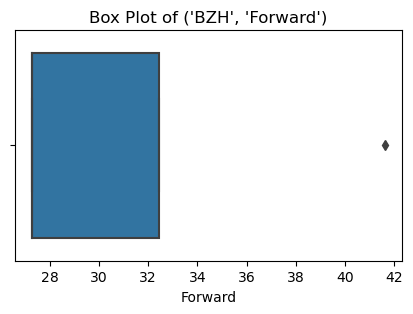

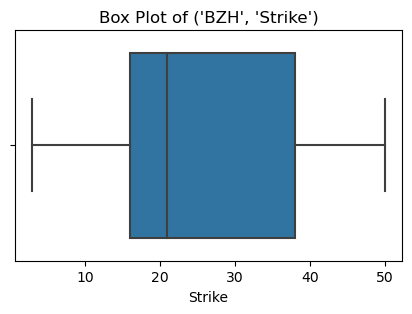

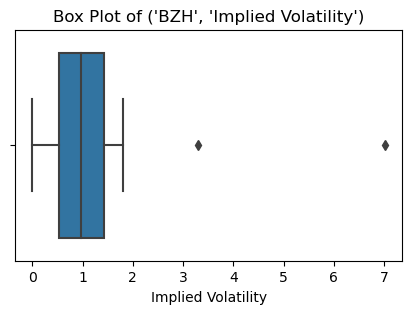

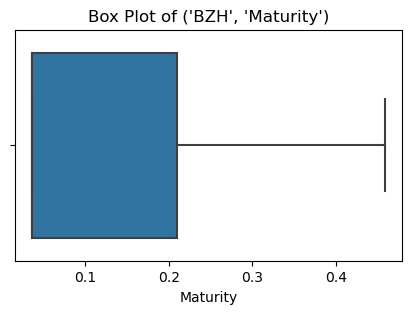

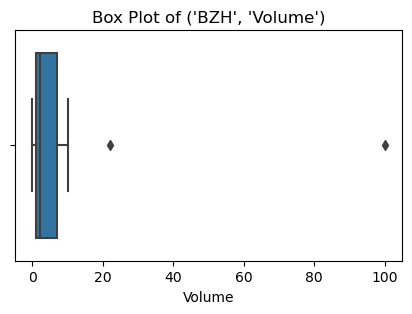

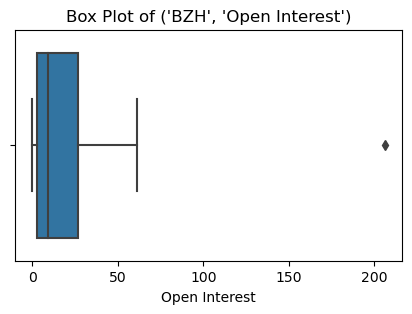

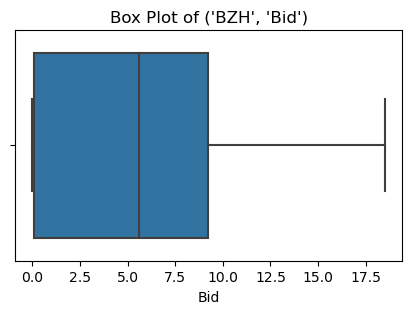

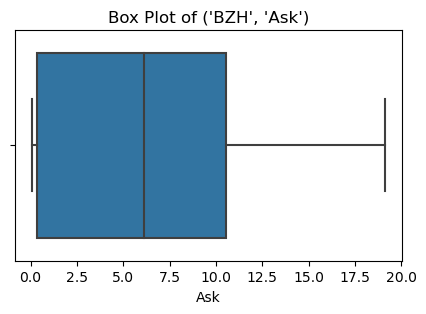

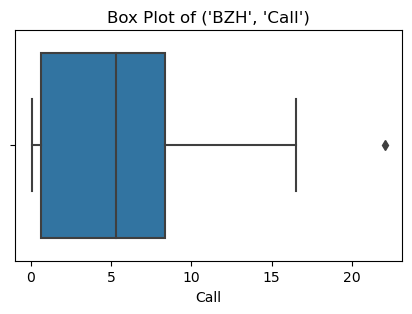

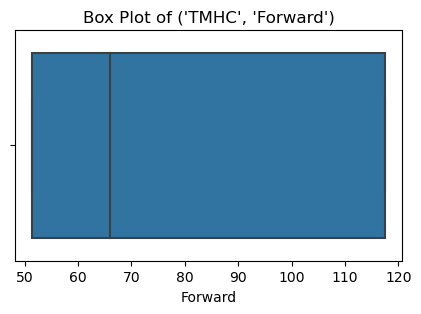

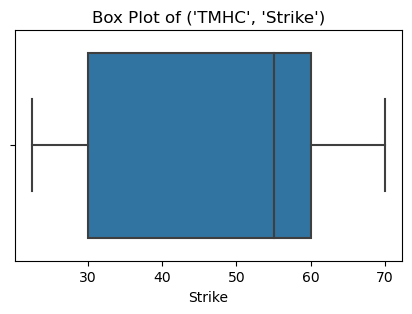

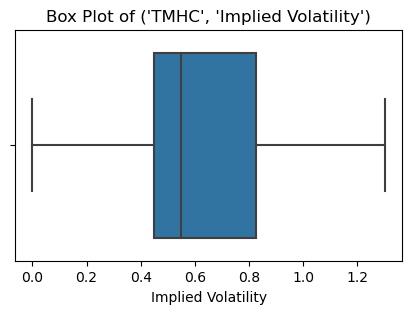

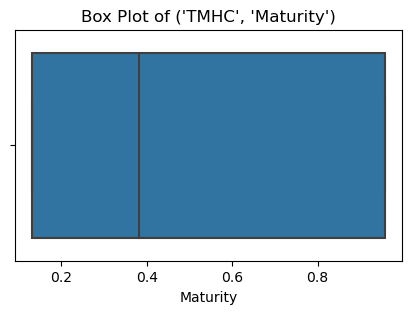

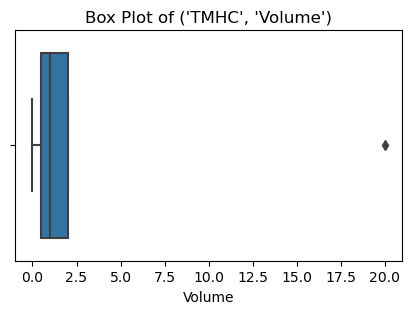

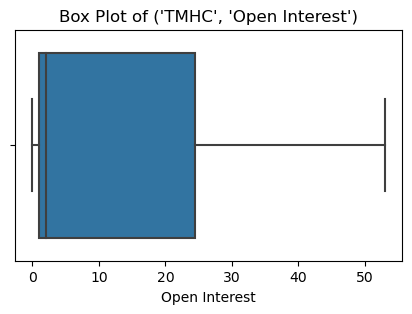

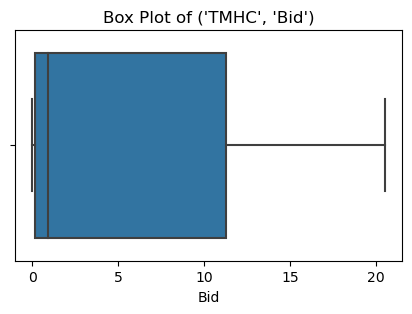

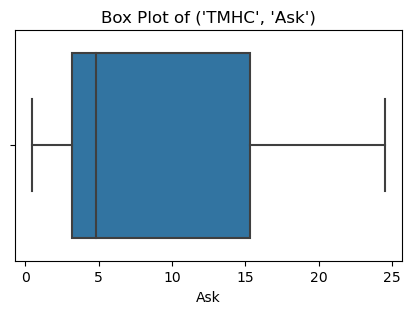

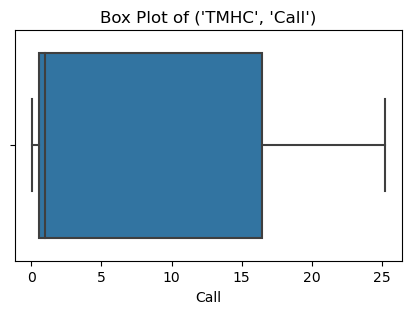

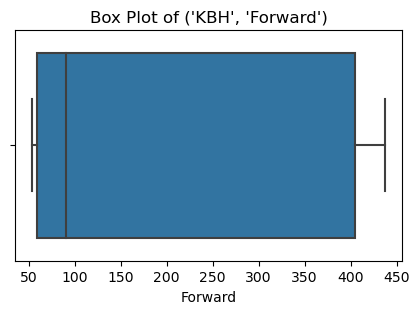

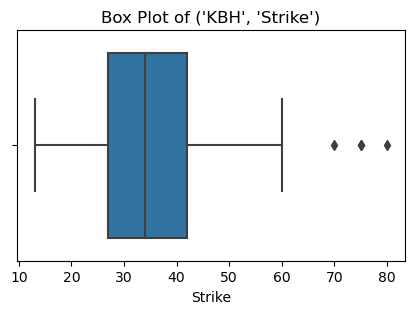

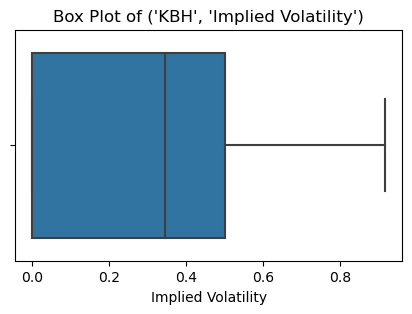

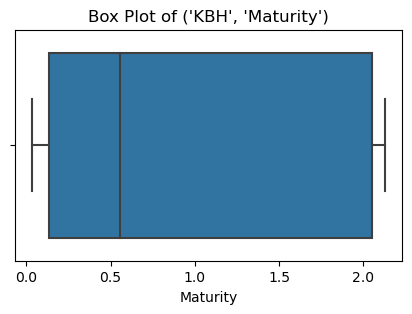

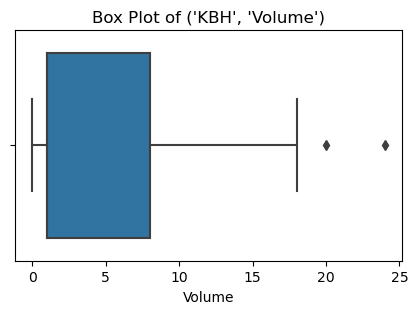

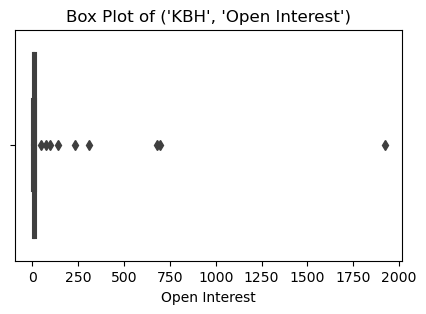

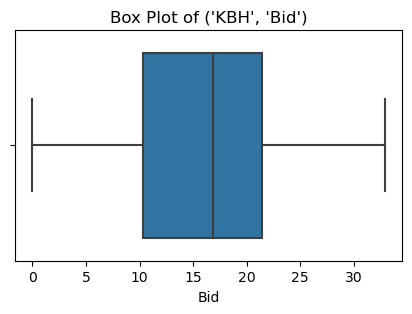

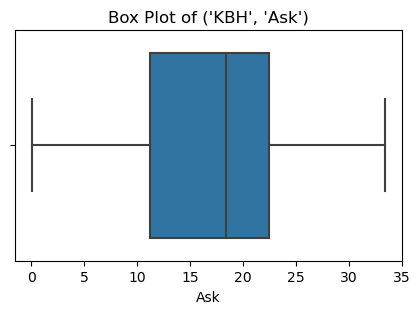

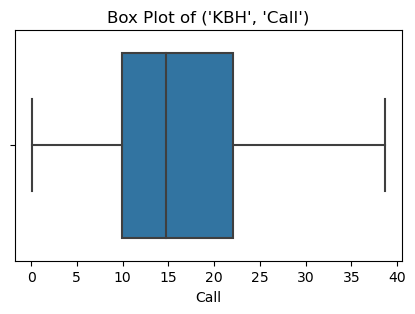

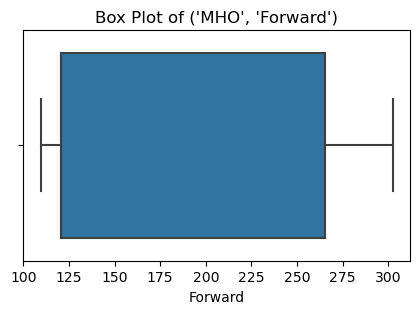

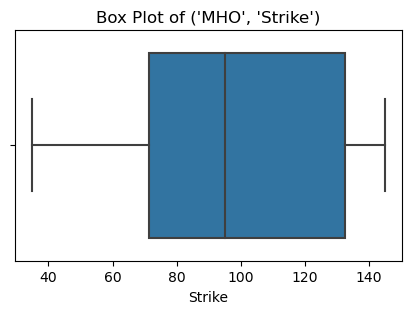

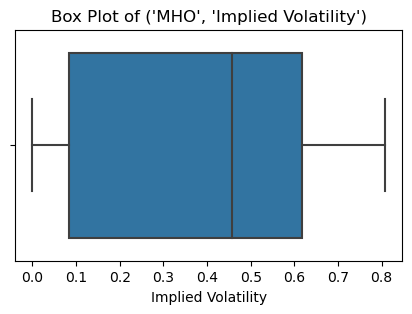

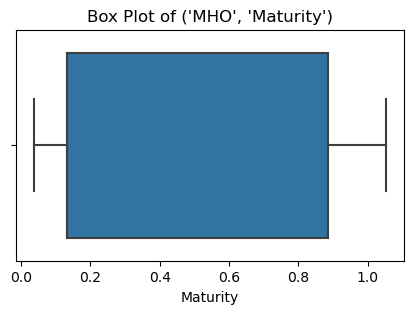

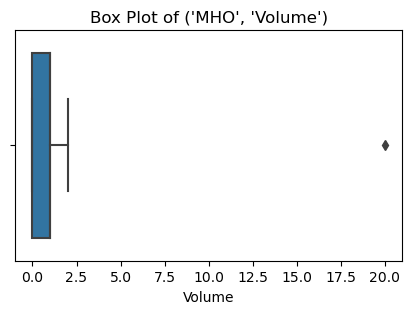

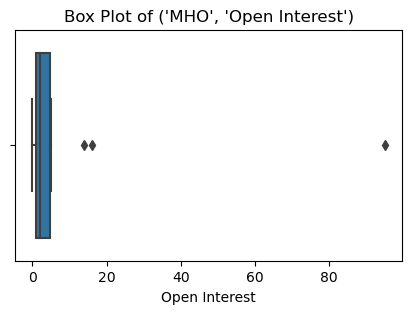

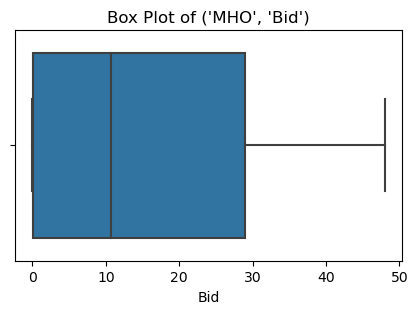

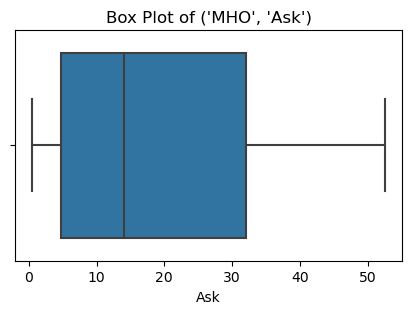

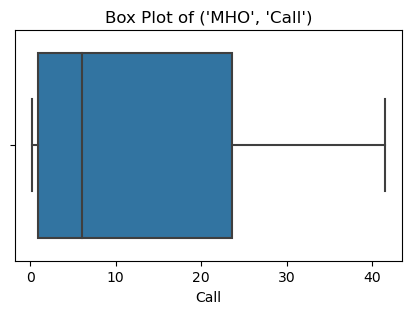

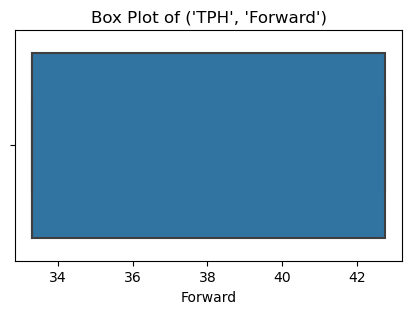

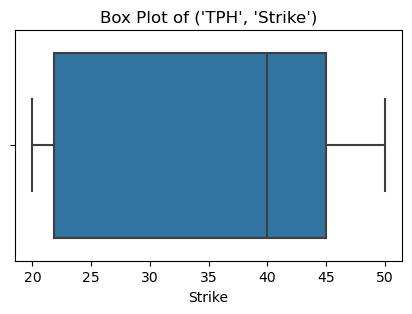

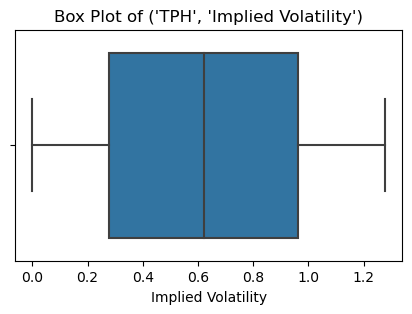

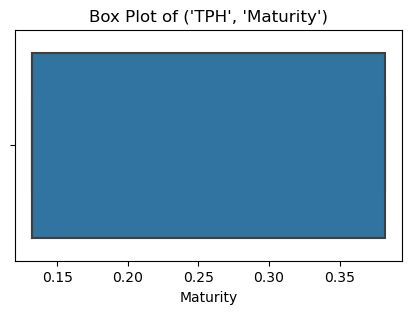

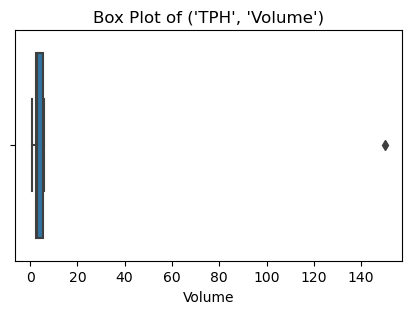

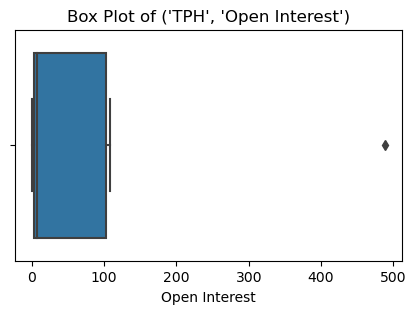

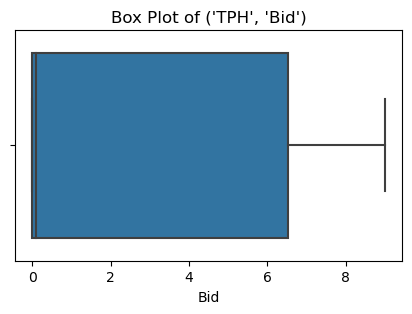

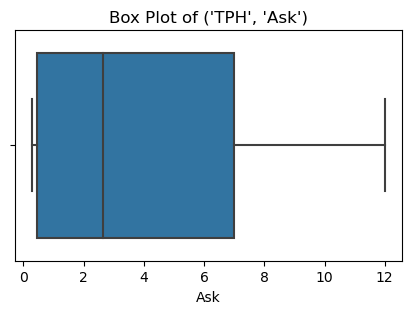

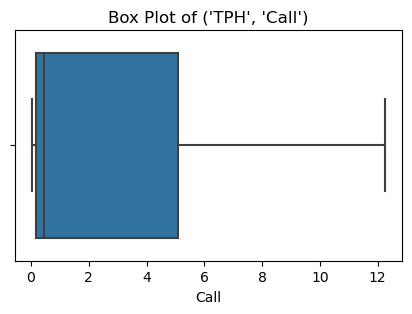

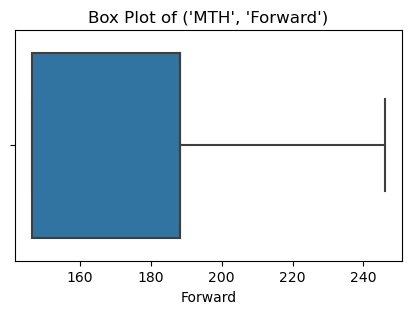

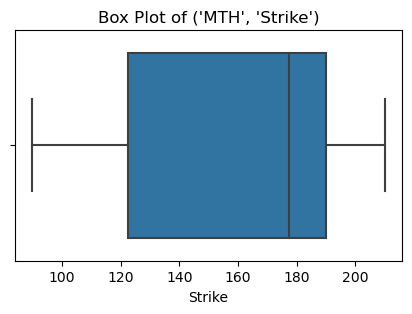

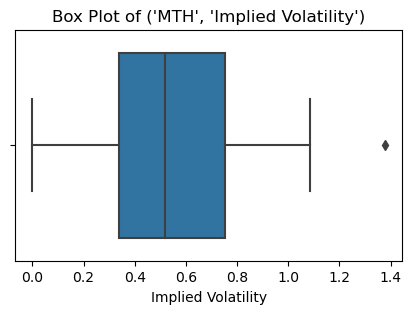

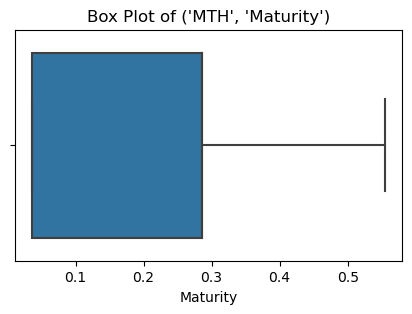

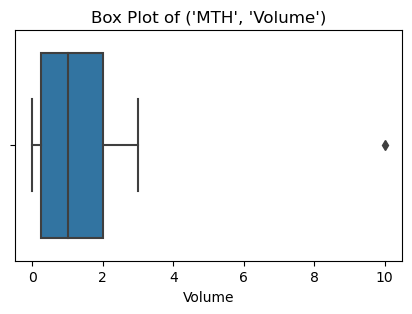

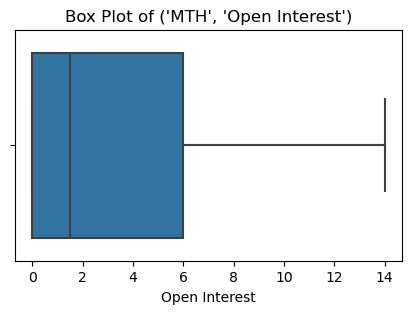

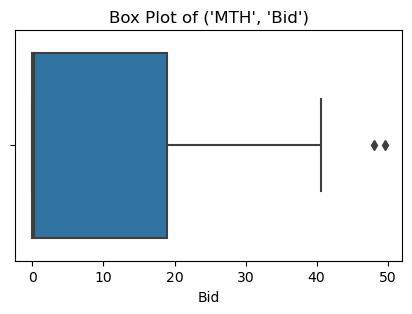

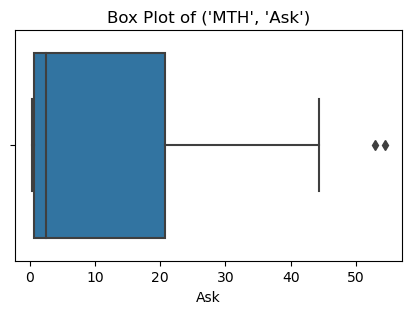

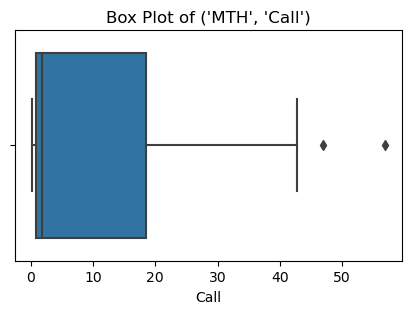

In [771]:
for i in range(len(options)):
    for column in options[i].columns:
        plt.figure(figsize=(5, 3))
        sns.boxplot(x=options[i][column])
        plt.title(f'Box Plot of {stock_ticker[i],column}')
        plt.xlabel(column)
        plt.show()

### In this case, we cannot transform the call price (y) as we are not able to transform the results back to the real price. As a consiquence, we cannot transform data separately with the same scaler, as this will lead to the x that has the same shape but very different y, so it won't be a good model. It's also not good to transform x together after merge as the x in same stock will have very similar value. In this case, it won't be able to have good predictions for the single option, but all options for the same stock get similar results.
### Looking into the data, we tried a few transformations. However, more complex data transformation does not necessarily give better results, so in the end, what we do is:
#### Volume and Open Interest are both negatively skewed, so we appy log(1+x) transformation to it.

In [772]:
scaler = StandardScaler()
for i in range(len(options)):

    options[i]['Volume'] = np.log1p(options[i][['Volume']].values)
    options[i]['Open Interest'] = np.log1p(options[i][['Open Interest']].values)
#     options[i]['FS'] = options[i]['Forward']-options[i]['Strike']
#     options[i] = options[i].drop(['Forward', 'Strike'], axis=1)
#     options[i]['BA'] = (options[i]['Bid']+options[i]['Ask'])/2
#     options[i] = options[i].drop(['Bid', 'Ask'], axis=1)

In [773]:
train_combined = pd.concat(options[1:], axis=0)
test = options[0]

In [774]:
y_train = train_combined['Call']
y_test = test['Call']
x_train = train_combined.drop('Call', axis=1)
x_test = test.drop('Call',axis=1)

In [775]:
x_test

,Forward,Strike,Implied Volatility,Maturity,Volume,Open Interest,Bid,Ask
0,27.292055,3.0,0.000010,0.036647,3.135494,3.135494,10.60,11.60
1,27.292055,5.0,0.000010,0.036647,0.693147,1.386294,17.00,17.80
2,27.292055,8.0,0.000010,0.036647,0.000000,0.693147,5.60,6.10
4,27.292055,11.0,7.015626,0.036647,0.000000,1.609438,18.50,19.10
6,27.292055,15.0,1.796876,0.036647,0.693147,0.000000,10.40,11.50
7,27.292055,16.0,0.000010,0.036647,2.079442,2.197225,7.10,7.50
9,27.292055,18.0,1.445315,0.036647,2.397895,3.295837,7.90,9.30
10,27.292055,19.0,3.301760,0.036647,1.386294,2.302585,9.30,11.20
28,27.292055,37.0,0.964844,0.036647,1.098612,1.098612,0.05,0.15
29,27.292055,38.0,1.023442,0.036647,1.098612,1.098612,0.00,0.20


# Training (40 points)
*10 points for correct code*

*10 points for selection judgement*

*10 points for hyperparameter optimization*

*10 points for resulting metrics*

---
In order to put together a set of training data, a selection of other stocks is provided by the analysts of G. Mane Investments:


You can use all of the stocks or just a selection to include in your training set, or all of them. Comment on the consideration between a bigger dataset and in/excluding a bias in your dataset.

Now that your training set is completed, you can train a Multi-Layered Perceptron Regressor (MLP) on it. Once it is trained, test it on your original dataset. First train it using the default hyperparameters, and then use _GridSearchCV_ to find the optimal hyperparameters. Observe the differences between the default and optimal hyperparameters and comment on it.

Instead of a classification problem, we are now facing a regression problem. Therefore, we observe the Mean Absolute Error (MAE) and the Root Mean Squared Error (RMSE) rather than the Confusion Matrix. Observe both metrics for both the default model as well as for the optimal hyperparameter model, and comment on the results. 

Suppose that you were to split the dataset of the original option data into a train and test set, and use these to train and test an MLP on. Would the metrics from that test be comparable with the previously calculated metrics? If yes, what would they explain? If no, why not?


In [776]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping, Callback

import sklearn
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

### First run the default setting. It is noticable that the model performs very differently. This may be caused by the fact that the prices are correlated (bid,ask,forward,strike), or the model is underfitted. Therefore, the model may converge to different minimums or not converge to minimum yet. In some cases, the predictions are good, while in others the model tends to predict mean, which means small prices are overvalued and big prices are undervalued.

Mean Absolute Error (MAE): 1.8280
Root Mean Squared Error (RMSE): 2.8089


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


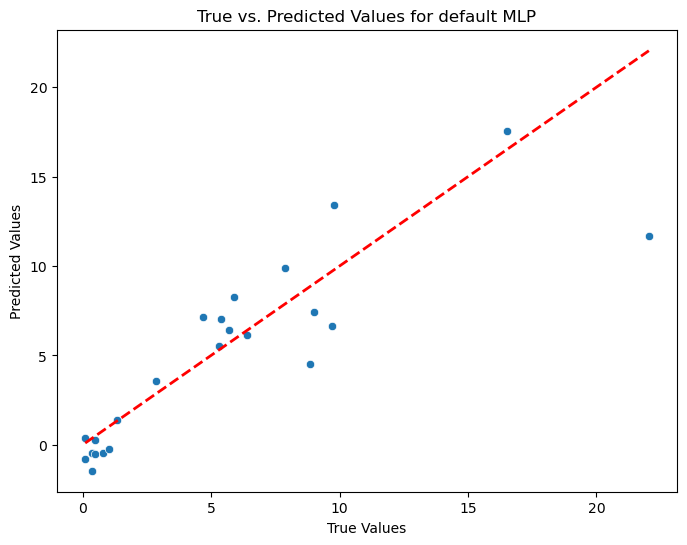

In [914]:
mlp_regressor = MLPRegressor()
mlp_regressor.fit(x_train, y_train)
y_pred = mlp_regressor.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred.flatten())
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values for default MLP')
plt.show()

### We grid search for the best model using the following parameters:
#### Activation: activation decides which function is used in the hidden layer, so there might be big difference if we use different activation.
#### Learning rate and initial rate: Learning rate determines the step size at each iteration while moving toward a minimum of a loss function, a small learning rate may lead to local minimum instead of global minimum. A large learning rate may lead to divergence. So it's a imporatent parameter.
#### Hidden layer size: It decides the structure of the hidden layers. If it's too much, it may lead to overfit. On the other hand, if it is too simple, it may lead to underfit. Therefore, it is also an important parameter to search.

### Additionally, the neg_mean_absolute_error is used in the grid search, so we maximize negative MAE, which is same as minimize MAE.

In [977]:
model_search = MLPRegressor()
parameters ={ 'activation': ['relu', 'tanh', 'identity'],
         'learning_rate':['constant', 'invscaling', 'adaptive'],
             'hidden_layer_sizes':[(16,8),(32,8),(64,4),(128,4),(256,),(128,2,),(128,),(64,8)],
             'learning_rate_init': [0.0001,0.001, 0.01, 0.1]}
grid_search = GridSearchCV(model_search, parameters,cv=3,verbose=2,scoring ='neg_mean_absolute_error')
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(best_model)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu,

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tan

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activ

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activ

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=constant, learning_rate_init=0.1; total time= 

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(16, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.0001; total time=

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=constant, learning_rate_init=0.01; tota

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_ra

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.001; 

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(32, 8), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=invscaling, learning_rate_init=0.001;

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 4), learning_rate=adaptive, learning_rate_init=0.1; total t

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.0001; t

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_ini

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 4), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001; total 

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.0001; total time

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=invscaling, learning_rate_init=0.1; to

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(256,), learning_rate=adaptive, learning_rate_init=0.01; total time= 

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=constant, learning_rate_init=0.1; tota

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=invscaling, learning_rat

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128, 2), learning_rate=adaptive, learning_rate_init=0.1; tota

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=constant, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=invscaling, learning_rate_init=0.1; to

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(128,), learning_rate=adaptive, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=constant, learning_rate_init=0.01; tota

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0.1; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=invscaling, learning_rate_init=0

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.0001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.001; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.01; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=(64, 8), learning_rate=adaptive, learning_rate_init=0.01; tota

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


### We noticed the grid search may not necessarily return the best model due to the problem that the model can perform very different using same parameter and same input. Therefore, we choose MLPRegressor(activation='identity', hidden_layer_sizes=(256,)) not because it returns the minimum MAE but it is the most stable model, which means it is the least likely to have large MAE. (but sometimes it still occurs the situation that the model tends to predict mean and give large MAE.)

Mean Absolute Error (MAE): 1.7373
Root Mean Squared Error (RMSE): 3.0224


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


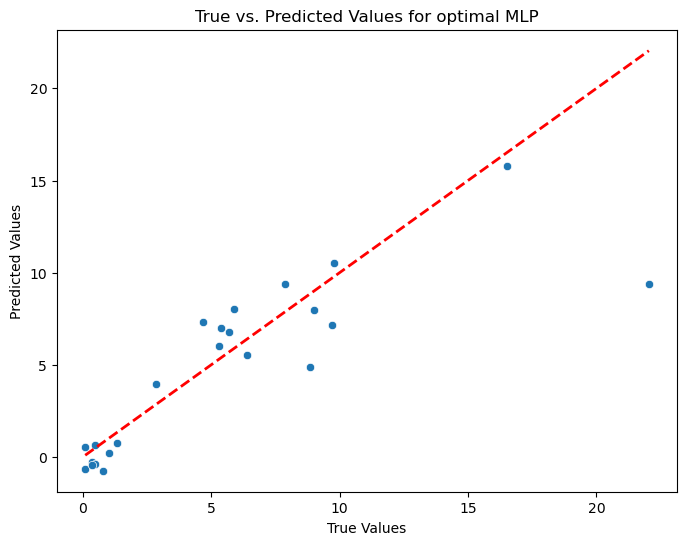

In [1084]:
mlp_regressor_optm = MLPRegressor(activation='identity', hidden_layer_sizes=(256))
mlp_regressor_optm.fit(x_train, y_train)
y_pred2 = mlp_regressor_optm.predict(x_test)
mae2 = mean_absolute_error(y_test, y_pred2)
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred2))
print(f'Mean Absolute Error (MAE): {mae2:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse2:.4f}')
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred2.flatten())
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values for optimal MLP')
plt.show()

# Recommendation (30 points)
*10 points for SHAP observation*

*10 points for explainability AI*

*10 points for recommendation*

---
Now that you've made an assessment of the transferability of option data, it is time to assess the SHAP values for each included feature. Observe the importance values and comment on the outliers.

Write a recommendation to the managers of G. Mane Investments. Explain what you have researched and present your results in a short paper in no more than 400 words. Focus on the fund's wants and needs, but don't hold back too much on the technical talk. The fund managers would like to discuss your paper with their analysts, who know more than basic maths, but aren't as up-to-date as you on AI. Make sure to cover the different levels of explainability, and the associated concerns.

We recommend writing in LaTeX/Overleaf, but Word or another application is also fine. Hand the paper in as PDF, together with your Jupyter Notebook, in a ZIP-file.

In [1085]:
import shap

### The shap summary plot is shown below, which shows that Bid and Ask are two most important features and positive correlated to the price. Implied volatility also has an effect but negatively correlated to the price. More detailed explanation and recommendation is in the paper.

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


  0%|          | 0/23 [00:00<?, ?it/s]

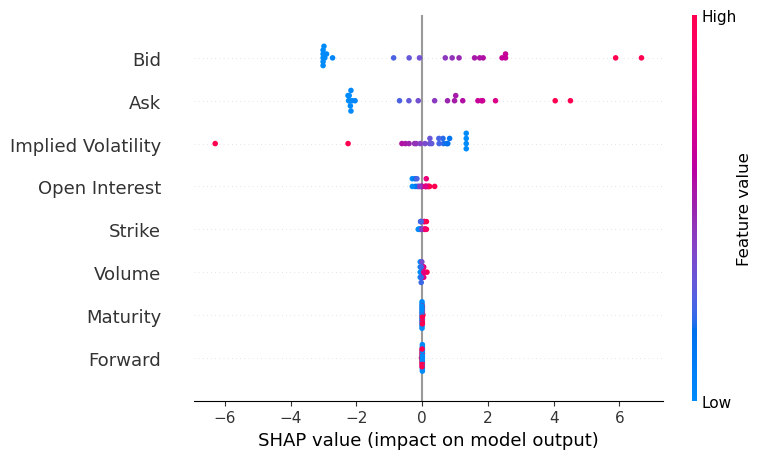

In [1086]:
shap.initjs()
k_explainer = shap.KernelExplainer(mlp_regressor_optm.predict, shap.kmeans(x_test, 20))
k_shap_values = k_explainer.shap_values(x_test)
shap.summary_plot(k_shap_values, x_test)